In [24]:
# implement the RotNet models with Network-In-Network (NIN) architectures
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm 
import PIL
import numpy as np
import torchvision.transforms as transforms
import datamodule
import math

train_dataset_path = './dataset/train'
unlabeled_dataset_path = './dataset/unlabelled'
num_workers = 2
batch_size = 36
# transform as you would input into alexnet
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    
])

data = datamodule.DataModule(train_dataset_path, unlabeled_dataset_path, train_transform, batch_size, num_workers)
dl_labeled = data.dloader_labeled()
dl_unlabeled = data.dloader_unlabeled()

#In order to train them on the rotation prediction task, we use SGD with batch size 128, momentum 0.9, weight decay 5e − 4 and lr of 0.1. 
#We drop the learning rates by a factor of 5 after epochs 30, 60, and 80. We train in total for 100 epochs. 
#In our preliminary experiments we found that we get significant improvement when during training we train the network by feeding it all the four rotated copies of an image simultaneously instead of each time randomly sampling a single rotation transformation. 
# Therefore, at each training batch the network sees 4 times more images than the batch size

In [25]:
# Augment the unlabeled dataset with four rotated copies of each image
# The rotation labels are 0, 1, 2, 3 for 0, 90, 180, 270 degrees
def generate_rotations(batch):
    angles = [0, 90, 180, 270]
    batch_size = batch.shape[0]
    batch_rotated = torch.zeros((batch_size*4, batch.shape[1], batch.shape[2], batch.shape[3]))
    for i in range(batch_size):
        for j in range(4):
            batch_rotated[i*4+j] = torchvision.transforms.functional.rotate(batch[i], angles[j])
    return batch_rotated

    

/home/eliott/.local/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/eliott/.local/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be co

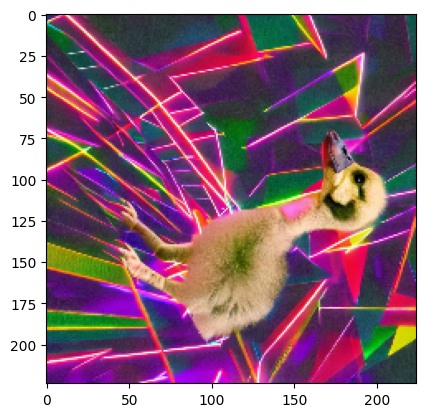

tensor([[[0.0567, 0.0644, 0.0791,  ..., 0.1401, 0.1627, 0.1507],
         [0.0633, 0.0681, 0.0523,  ..., 0.1817, 0.1840, 0.1599],
         [0.0725, 0.0439, 0.0384,  ..., 0.1166, 0.1658, 0.1665],
         ...,
         [0.2429, 0.2031, 0.2147,  ..., 0.2903, 0.2755, 0.2838],
         [0.2412, 0.2530, 0.2952,  ..., 0.3177, 0.3124, 0.2775],
         [0.1948, 0.2190, 0.2818,  ..., 0.2804, 0.2817, 0.2735]],

        [[0.3194, 0.3272, 0.3418,  ..., 0.2123, 0.2451, 0.2331],
         [0.3261, 0.3308, 0.3151,  ..., 0.2601, 0.2663, 0.2540],
         [0.3353, 0.3067, 0.3012,  ..., 0.1990, 0.2599, 0.2645],
         ...,
         [0.1718, 0.1342, 0.1470,  ..., 0.0505, 0.0554, 0.0720],
         [0.1443, 0.1407, 0.1806,  ..., 0.0860, 0.1006, 0.0735],
         [0.1653, 0.1552, 0.1694,  ..., 0.0490, 0.0778, 0.0808]],

        [[0.2841, 0.2919, 0.3065,  ..., 0.2193, 0.2568, 0.2527],
         [0.2908, 0.2955, 0.2798,  ..., 0.2640, 0.2781, 0.2697],
         [0.3000, 0.2714, 0.2659,  ..., 0.2029, 0.2677, 0.

In [21]:
# print a single image from the dataset

image = next(iter(dl_unlabeled))
# plot image 
import matplotlib.pyplot as plt
plt.imshow(image[0].permute(1, 2, 0))
batch_rotated = generate_rotations(image)
plt.imshow(batch_rotated[0].permute(1, 2, 0))
plt.imshow(batch_rotated[1].permute(1, 2, 0))
plt.imshow(batch_rotated[2].permute(1, 2, 0))
plt.imshow(batch_rotated[3].permute(1, 2, 0))
plt.show()
print(image[0])

In [36]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super(BasicBlock, self).__init__()
        padding = (kernel_size-1)//2
        self.conv =  nn.Conv2d(in_planes, out_planes, \
            kernel_size=kernel_size, stride=1, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        return F.relu(self.bn(self.conv(x)))
    
class GlobalAveragePooling(nn.Module):
    def __init__(self):
        super(GlobalAveragePooling, self).__init__()

    def forward(self, feat):
        num_channels = feat.size(1)
        return F.avg_pool2d(feat, (feat.size(2), feat.size(3))).view(-1, num_channels)
    
class NIN(nn.Module):
    def __init__(self, numclasses, numblocks=4):
        self.numclasses = numclasses
        self.numblocks = numblocks
        super(NIN, self).__init__()
        

        assert(numblocks >= 3)
        nChannels  = 192
        nChannels2 = 160
        nChannels3 = 96

        blocks = [nn.Sequential() for i in range(numblocks)]
        # 1st block
        blocks[0].add_module('Block1_ConvB1', BasicBlock(3, nChannels, 5))
        blocks[0].add_module('Block1_ConvB2', BasicBlock(nChannels,  nChannels2, 1))
        blocks[0].add_module('Block1_ConvB3', BasicBlock(nChannels2, nChannels3, 1))
        blocks[0].add_module('Block1_MaxPool', nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

        # 2nd block
        blocks[1].add_module('Block2_ConvB1',  BasicBlock(nChannels3, nChannels, 5))
        blocks[1].add_module('Block2_ConvB2',  BasicBlock(nChannels,  nChannels, 1))
        blocks[1].add_module('Block2_ConvB3',  BasicBlock(nChannels,  nChannels, 1))
        blocks[1].add_module('Block2_AvgPool', nn.AvgPool2d(kernel_size=3,stride=2,padding=1))

        # 3rd block
        blocks[2].add_module('Block3_ConvB1',  BasicBlock(nChannels, nChannels, 3))
        blocks[2].add_module('Block3_ConvB2',  BasicBlock(nChannels, nChannels, 1))
        blocks[2].add_module('Block3_ConvB3',  BasicBlock(nChannels, nChannels, 1))

        if numblocks > 3:
            blocks[2].add_module('Block3_AvgPool', nn.AvgPool2d(kernel_size=3,stride=2,padding=1))
        for s in range(3, numblocks):
            blocks[s].add_module('Block'+str(s+1)+'_ConvB1',  BasicBlock(nChannels, nChannels, 3))
            blocks[s].add_module('Block'+str(s+1)+'_ConvB2',  BasicBlock(nChannels, nChannels, 1))
            blocks[s].add_module('Block'+str(s+1)+'_ConvB3',  BasicBlock(nChannels, nChannels, 1))

        blocks.append(nn.Sequential())
        blocks[-1].add_module('GlobalAveragePooling',  GlobalAveragePooling())
        blocks[-1].add_module('Classifier', nn.Linear(nChannels, numclasses))

        self.blocks = nn.Sequential(*blocks)

    def forward(self,x):
        return self.blocks(x)
    



In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

numblocks = 5
rotnet = NIN(4, numblocks)

# Initialize the weights of the network
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        if m.weight.requires_grad:
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            nn.init.normal_(m.weight.data,0, math.sqrt(2. / n))
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

rotnet.apply(weights_init)

cpu


NIN(
  (blocks): Sequential(
    (0): Sequential(
      (Block1_ConvB1): BasicBlock(
        (layers): Sequential(
          (Conv): Conv2d(3, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2.0, 2.0), bias=False)
          (BatchNorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (ReLU): ReLU(inplace=True)
        )
      )
      (Block1_ConvB2): BasicBlock(
        (layers): Sequential(
          (Conv): Conv2d(192, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (BatchNorm): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (ReLU): ReLU(inplace=True)
        )
      )
      (Block1_ConvB3): BasicBlock(
        (layers): Sequential(
          (Conv): Conv2d(160, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (BatchNorm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (ReLU): ReLU(inplace=True)
        )
      )
      (Block1_Ma

In [33]:

# optimize, try adam
optimizer = torch.optim.SGD(rotnet.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
# We drop the learning rates by a factor of 5 after epochs 30, 60, and 80. We train in total for 100 epochs.

criterion = nn.CrossEntropyLoss()
rotnet.to(device)

num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    for numbatch, batch in tqdm(enumerate(dl_unlabeled)):
        # augment the batch with 4 rotated copies
        batch_rotated = generate_rotations(batch)
        # move batch to device
        batch = batch.to(device)
        # forward pass
        print(batch_rotated.shape)
        
        output = rotnet(batch_rotated)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        # compute loss
        loss = criterion(pred, torch.tensor([0, 1, 2, 3]*batch.shape[0]))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print loss
        if numbatch % 100 == 0:
            print('Epoch: {}, Batch: {}, Loss: {}'.format(epoch, numbatch, loss.item()))
    # drop learning rate
    if epoch == 30 or epoch == 60 or epoch == 80:
        for param_group in optimizer.param_groups:
            param_group['lr'] /= 5.0




0it [00:00, ?it/s]/100 [00:00<?, ?it/s]

torch.Size([144, 3, 224, 224])



  0%|          | 0/100 [00:01<?, ?it/s]


TypeError: conv2d() received an invalid combination of arguments - got (Tensor, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (Tensor, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (float, float)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (Tensor, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (float, float)!, !tuple of (int, int)!, int)


In [37]:
block = BasicBlock(3, 192, 5)
print(block)
random_input = torch.randn(1, 3, 32, 32)
block(random_input)

BasicBlock(
  (conv): Conv2d(3, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2.0, 2.0), bias=False)
  (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


TypeError: conv2d() received an invalid combination of arguments - got (Tensor, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (Tensor, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (float, float)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (Tensor, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (float, float)!, !tuple of (int, int)!, int)
